In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import io,color,measure,feature
from sklearn import cluster,datasets
from scipy import signal
from fcmeans import FCM
import skfuzzy as fuzz
from skimage.transform import resize
from numpy import ndarray as npnd

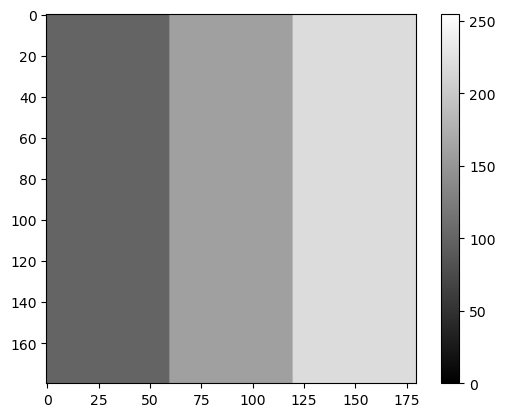

(<Figure size 640x480 with 2 Axes>,
 None)

In [2]:
L = 256
h = 180
w = 180

img = np.zeros([h,w])

img[:,0:60] = 100
img[:,60:120] = 160
img[:,120:180] = 220

plt.figure(), plt.imshow(img,cmap='gray',vmin=0,vmax=255),plt.colorbar(),plt.show()

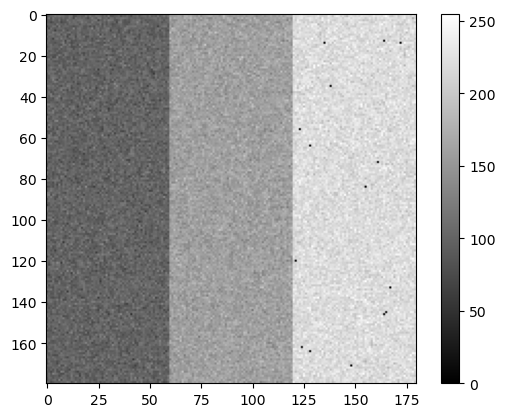

(<Figure size 640x480 with 2 Axes>,
 None)

In [3]:
def add_gaussian_noise(img,disp):
    # parametrii : imaginea originala, dispersia zgomotului
    h,w = img.shape
    noise = np.random.normal(0,disp,(h,w)) #distributie normala de medie 0
    img_noise = np.zeros([h,w])
    img_noise = img + noise
    img_noise = np.uint8(img_noise)
    # intoarce imaginea cu zgomot
    return img_noise

img_zg = add_gaussian_noise(img,12)
plt.figure(), plt.imshow(img_zg,cmap='gray',vmin=0,vmax=255),plt.colorbar(),plt.show()

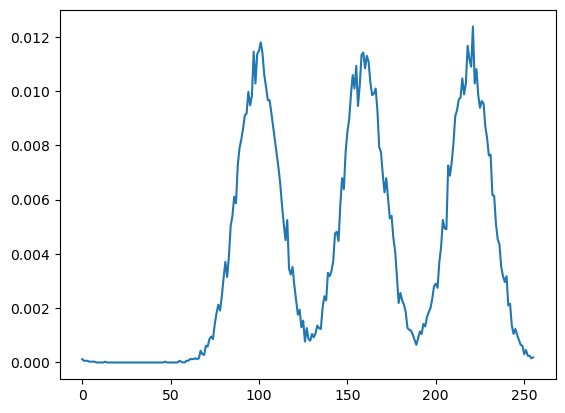

(<Figure size 640x480 with 1 Axes>,
 None)

In [4]:
def histograma(img,L):#L numarul de niveluri de gri
    [Linii,Coloane] = img.shape
    hist = np.zeros([L])
    for l in range(0,Linii):
        for c in range(0,Coloane):
            hist[img[l,c]] = hist[img[l,c]]+1
    return hist/(Linii*Coloane)

hist  = histograma(img_zg,L)
x = np.array(list(range(256)))
plt.figure(), plt.plot(x, hist),plt.show()

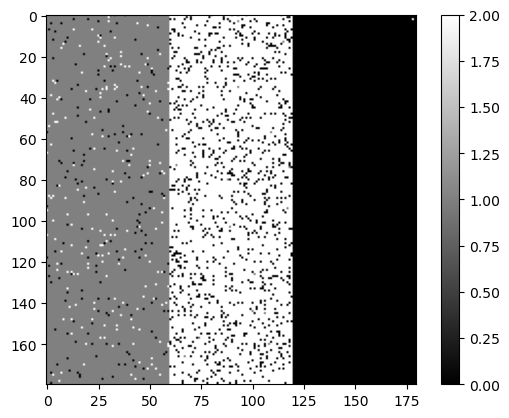

(<Figure size 640x480 with 2 Axes>,
 None)

In [5]:
def segmentareClase(img):
    [h,w] = img.shape
    Y = np.zeros([h,w],dtype = np.uint8)
    object1 = [75,125]
    object2 = [125,175]
    object3 = [175,250]
    for i in range(h):
        for j in range(w):
            if img[i,j] in range(object1[0],object1[1]):
                Y[i,j] = 1
            else: 
                if img[i,j] in range(object2[0],object2[1]):
                    Y[i,j] = 2
                else: 
                    if img[i,j] in range(object3[0],object3[1]):
                        Y[i,j] = 0
    return Y

img_seg = segmentareClase(img_zg)
plt.figure(),plt.imshow(img_seg,cmap="gray"),plt.colorbar(),plt.show()

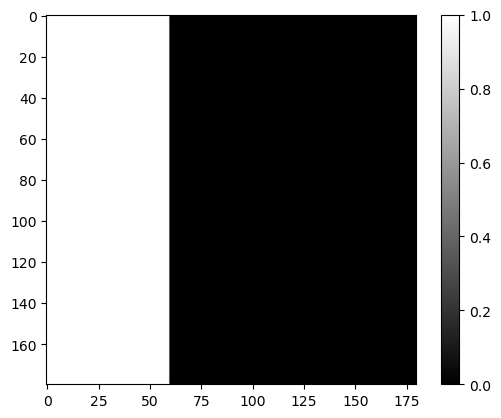

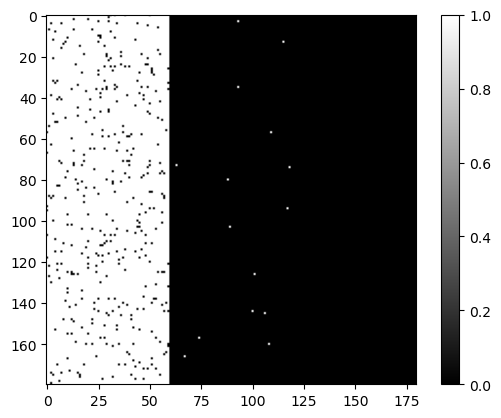

(<Figure size 640x480 with 2 Axes>,
 None)

In [15]:
T=125
mask=(img<=T)
plt.figure(),plt.imshow(mask,cmap="gray"),plt.colorbar(),plt.show()

T=1
img_binarizata=(img_seg==T)
plt.figure(),plt.imshow(img_binarizata,cmap="gray"),plt.colorbar(),plt.show()

In [16]:
def PrecRec(MASK,SEGM):#mask -> masca, segm -> segmentarea facuta
    epsilon=0.00001
    TP=SEGM*MASK
    FP=SEGM*(1-MASK)
    FN=(1-SEGM)*MASK
    prec=np.sum(TP)/(np.sum(TP)+np.sum(FP)+epsilon)#cat % s-a segmentat corect
    rec=np.sum(TP)/(np.sum(TP)+np.sum(FN)+epsilon)# cat % s-a segmentat din corect
    return prec,rec

print(PrecRec(mask,img_binarizata)[0])

0.9985623912223861


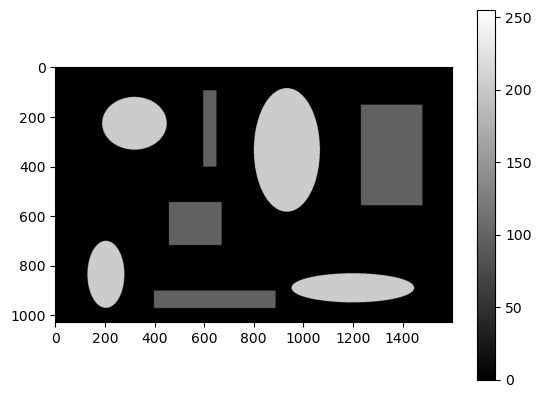

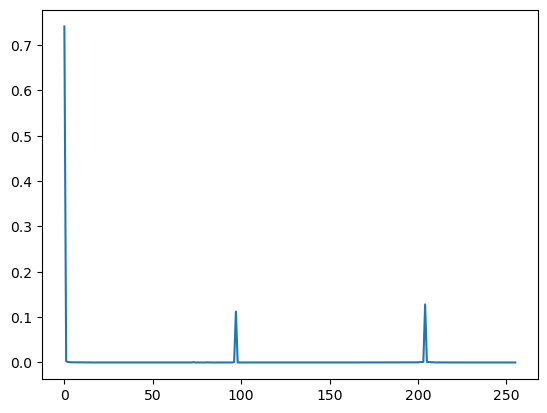

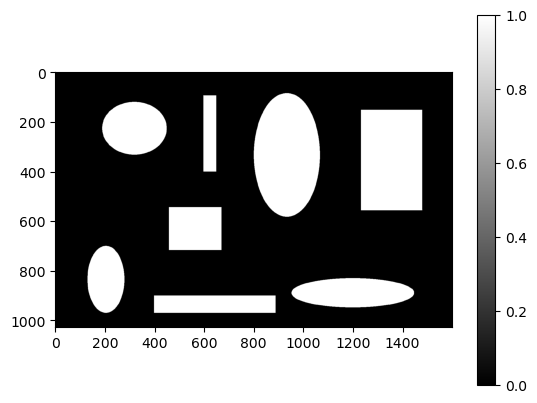

(<Figure size 640x480 with 2 Axes>,
 None)

In [8]:
img1 = io.imread("sub2.png") 

# de verificat sa nu cumva sa fie imaginea color => o fac uint8 gri
# daca imaginea este gri => o facem uint8

img1_grey = np.uint8(255*color.rgb2gray(img1))

plt.figure(), plt.imshow(img1,cmap='gray',vmin=0,vmax=255),plt.colorbar(),plt.show()


h,_=np.histogram(img1_grey,bins=256,range=(0,256),density=True)
plt.figure(),plt.plot(h),plt.show()

BW=np.uint8(img1_grey>75) #imaginea binarizata
plt.figure(),plt.imshow(BW,cmap="gray"),plt.colorbar(),plt.show()

8


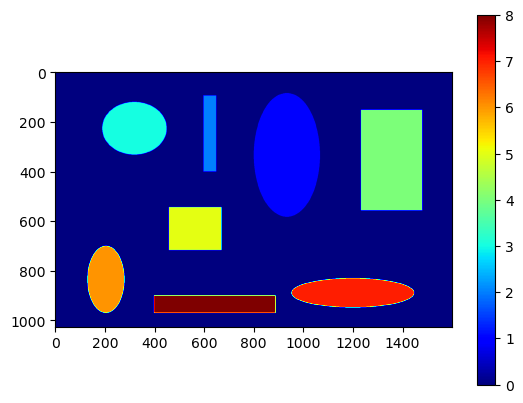

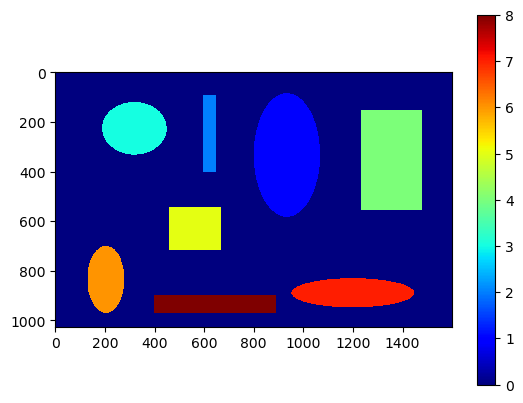

(<Figure size 640x480 with 2 Axes>,
 None)

In [9]:
### ETICHETARE ###
[LabelImage, nums]=measure.label(BW,return_num='True')
print(nums)
plt.figure(),plt.imshow(LabelImage,cmap="jet"),plt.colorbar(),plt.show()#cu interpolare 
#face un antialias pe zonele de contur
plt.figure(),plt.imshow(LabelImage,cmap="jet",interpolation='none'),plt.colorbar(),plt.show()

8


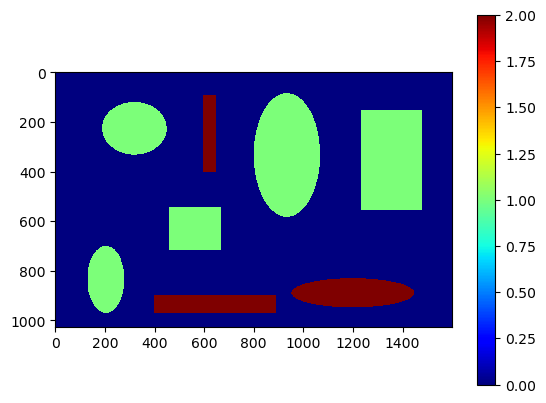

(<Figure size 640x480 with 2 Axes>,
 None)

In [39]:
# fiecare obiect in parte
ALLPROPS=measure.regionprops(LabelImage)
size=len(ALLPROPS)
print(size)
features = np.zeros([1,8]) ### de modificat nr obiecte ###
for i in range(0,len(ALLPROPS)):
        features[0,i] = (ALLPROPS[i].perimeter**2)/(ALLPROPS[i].area*4*np.pi)

features = np.transpose(features)
        
# clustering
kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(features)
etichete = kmeans.labels_
centroizi = kmeans.cluster_centers_
img_cluster = np.zeros(np.shape(LabelImage))
h,w = np.shape(LabelImage)
for i in range(0,h):
    for j in range(0,w):
        if LabelImage[i, j] != 0:
            img_cluster[i,j]=etichete[LabelImage[i,j]-1]+1
            
plt.figure(), plt.imshow(img_cluster, cmap="jet",interpolation='none'), plt.colorbar(), plt.show()

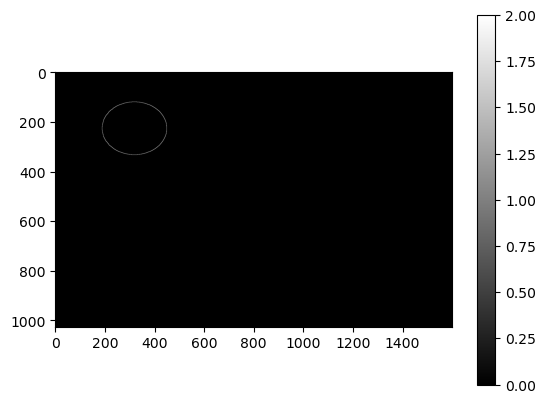

(<Figure size 640x480 with 2 Axes>,
 None)

In [11]:
minim = (ALLPROPS[0].perimeter**2)/(ALLPROPS[0].area*4*np.pi)
obiect = 0
for i in range(0,len(ALLPROPS)):
    rap=  (ALLPROPS[i].perimeter**2)/(ALLPROPS[i].area*4*np.pi)
    if(rap < minim):
        minim = rap
        obiect =i
img_obiect = np.zeros(np.shape(LabelImage))
img_obiect = np.uint8(LabelImage==obiect+1)

### CONTUR ###
fx=signal.convolve2d(img_obiect,np.array([[0,-1,0],[0,0,0],[0,1,0]]),boundary='symm', mode='same')
fy=signal.convolve2d(img_obiect,np.array([[0,0,0],[-1,0,1],[0,0,0]]),boundary='symm', mode='same')
gradY=np.abs(fx)+np.abs(fy) # harta de gradient
plt.figure(), plt.imshow(gradY, cmap='gray'), plt.colorbar(), plt.show()